# Filtro per Fake News
Il problema delle fake news è cresciuto esponenzialmente nell'ultimo decennio a causa della crescente diffusione dei social network, il governo degli Stati Uniti ha deciso di muoversi a tal proposito, incaricando la tua azienda di realizzare un plug-in per chrome in grado di riconoscere se una notizia è falsa. Il tuo compito è quello di realizzare il modello in grado di riconoscere le notizie false, che poi il team di machine learning enginner e web developer metterà in produzione. Ti vengono messi a disposizioni due raccolte di notizie, una contenente solo notizie false e l'altra contenente solo notizie vere, utilizzale per addestrare il tuo modello.

### [Link al dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip)

Parti da un'accurata analisi, rispondendo a domande come:
- le fake news sono più frequenti in una determinata categoria?
- per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?
- I titoli delle fake news presentano dei pattern?

Una volta addestrato il modello esportalo [utilizzando pickle](https://scikit-learn.org/stable/model_persistence.html) così che i tuoi colleghi possano metterlo in produzione.

## Importiamo i dataset

In [ ]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
!unzip fake_news.zip

--2024-03-04 11:25:20--  https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.224.123, 52.95.155.68
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.224.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42975911 (41M) [application/zip]
Saving to: ‘fake_news.zip.1’

fake_news.zip.1     100%[===================>]  40.98M  18.6MB/s    in 2.2s    

2024-03-04 11:25:23 (18.6 MB/s) - ‘fake_news.zip.1’ saved [42975911/42975911]

Archive:  fake_news.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Fake.csv                
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: True.csv                y



In [ ]:
import pandas as pd

In [ ]:
df_true = pd.read_csv("True.csv")
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df_fake = pd.read_csv("Fake.csv")
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import nltk
from nltk.corpus import stopwords
import pprint

import re
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

nltk.download('stopwords')
stop_words = stopwords.words('english')

df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

df_true['label'] = 1  # 1 per le notizie vere
df_fake['label'] = 0  # 0 per le notizie false

df = pd.concat([df_true, df_fake], ignore_index=True)

df_true['combined_text'] = df_true['title'] + " " + df_true['text']
df_fake['combined_text'] = df_fake['title'] + " " + df_fake['text']

df_combined = pd.concat([df_true[['combined_text', 'label']], df_fake[['combined_text', 'label']]], ignore_index=True)

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

df_combined['cleaned_text'] = df_combined['combined_text'].apply(remove_special_characters)
df_combined['cleaned_text'] = df_combined['cleaned_text'].apply(remove_numbers)

def sent_to_words(items):
    for item in items:
        yield(gensim.utils.simple_preprocess(str(item), deacc=True))

def remove_stopwords_and_short_words(texts):
    return [[word for word in words if word not in stop_words and len(word) >= 3] for words in texts]

combined_texts = df_combined['combined_text']
data_words = list(sent_to_words(combined_texts))
data_words = remove_stopwords_and_short_words(data_words)

# Creazione del dizionario e del corpus
id2word = Dictionary(data_words)
id2word.filter_extremes(no_below=5, no_above=0.95)
corpus = [id2word.doc2bow(text) for text in data_words]



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Addestramento del primo modello LDA che servirà per il confronto dei topic
lda_model = LdaModel(corpus=corpus,
                      id2word=id2word,
                      num_topics=20,
                      random_state=42,
                      chunksize=100,
                      passes=10,
                      per_word_topics=True)

# Visualizzazione dei topic
print("Topic:")
pprint.pprint(lda_model.print_topics())

# Visualizzazione della distribuzione dei topic per un documento di esempio
sample_doc_id = 0
print(f"Topic distribution for sample document (ID={sample_doc_id}):")
pprint.pprint(lda_model.get_document_topics(corpus[sample_doc_id]))

Topic:
[(0,
  '0.023*"fbi" + 0.021*"clinton" + 0.019*"russian" + 0.019*"russia" + '
  '0.011*"news" + 0.010*"information" + 0.010*"evidence" + 0.010*"report" + '
  '0.010*"story" + 0.010*"fake"'),
 (1,
  '0.050*"program" + 0.047*"government" + 0.035*"children" + 0.028*"funding" + '
  '0.027*"kids" + 0.021*"federal" + 0.020*"planned" + 0.020*"passage" + '
  '0.019*"food" + 0.019*"crisis"'),
 (2,
  '0.026*"police" + 0.013*"mainstream" + 0.012*"state" + 0.010*"city" + '
  '0.010*"said" + 0.010*"public" + 0.009*"law" + 0.008*"new" + 0.008*"also" + '
  '0.007*"according"'),
 (3,
  '0.122*"health" + 0.074*"medical" + 0.068*"care" + 0.068*"brain" + '
  '0.063*"hospital" + 0.039*"coverage" + 0.037*"obamacare" + 0.027*"insurance" '
  '+ 0.027*"cancer" + 0.025*"device"'),
 (4,
  '0.061*"wall" + 0.037*"border" + 0.033*"street" + 0.031*"bank" + '
  '0.026*"goldman" + 0.025*"jobs" + 0.025*"financial" + 0.023*"illegal" + '
  '0.022*"sachs" + 0.021*"mexico"'),
 (5,
  '0.031*"company" + 0.018*"interne

In [ ]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


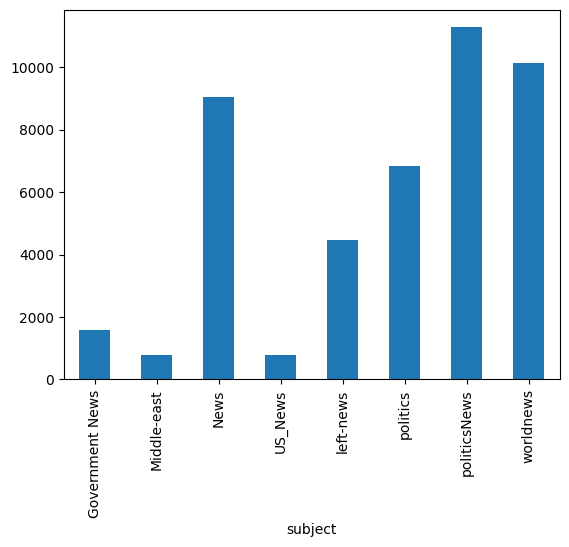

In [ ]:
# Numero notizie per argomento
import matplotlib.pyplot as plt
print(df.groupby(['subject'])['text'].count())
df.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [ ]:
# Concateniamo i testi delle fake news
fake_texts = df_fake['text']

fake_data_words = list(sent_to_words(fake_texts))

fake_data_words = remove_stopwords_and_short_words(fake_data_words)

fake_id2word = Dictionary(fake_data_words)

fake_id2word.filter_extremes(no_below=5, no_above=0.95)

fake_corpus = [fake_id2word.doc2bow(text) for text in fake_data_words]

# Addestramento del modello LDA per le fake news
fake_lda_model = LdaModel(corpus=fake_corpus,
                           id2word=fake_id2word,
                           num_topics=20,
                           random_state=42,
                           chunksize=100,
                           passes=10,
                           per_word_topics=True)

print("Topic per le fake news:")
pprint.pprint(fake_lda_model.print_topics())

sample_fake_doc_id = 0
print(f"Topic distribution for sample fake document (ID={sample_fake_doc_id}):")
pprint.pprint(fake_lda_model.get_document_topics(fake_corpus[sample_fake_doc_id]))


Topic per le fake news:
[(0,
  '0.013*"century" + 0.009*"war" + 0.008*"would" + 0.008*"american" + '
  '0.008*"world" + 0.007*"also" + 0.007*"military" + 0.007*"new" + '
  '0.007*"america" + 0.007*"states"'),
 (1,
  '0.045*"media" + 0.037*"news" + 0.019*"story" + 0.014*"new" + 0.013*"post" + '
  '0.012*"fake" + 0.009*"show" + 0.008*"times" + 0.008*"room" + 0.008*"week"'),
 (2,
  '0.020*"people" + 0.020*"like" + 0.018*"said" + 0.014*"would" + 0.014*"one" '
  '+ 0.012*"think" + 0.011*"going" + 0.011*"know" + 0.011*"even" + '
  '0.010*"get"'),
 (3,
  '0.183*"black" + 0.111*"white" + 0.052*"protests" + 0.050*"matter" + '
  '0.046*"flag" + 0.032*"racist" + 0.030*"race" + 0.030*"police" + '
  '0.025*"african" + 0.023*"protest"'),
 (4,
  '0.091*"university" + 0.083*"wall" + 0.077*"school" + 0.053*"street" + '
  '0.049*"college" + 0.045*"student" + 0.043*"bombing" + 0.040*"activists" + '
  '0.028*"district" + 0.027*"high"'),
 (5,
  '0.096*"political" + 0.061*"radio" + 0.054*"establishment" + 0

In [ ]:
# Calcolo della frequenza delle fake news per categoria
category_fake_news_freq = df[df['label'] == 0]['subject'].value_counts() / df['subject'].value_counts()
print("Frequenza delle fake news per categoria:")
print(category_fake_news_freq)


Frequenza delle fake news per categoria:
Government News    1.0
Middle-east        1.0
News               1.0
US_News            1.0
left-news          1.0
politics           1.0
politicsNews       NaN
worldnews          NaN
Name: subject, dtype: float64


In [ ]:
# Identificazione degli argomenti più comuni associati alle fake news per categoria
for category in df_fake['subject'].unique():
    print(f"\nCategoria: {category}")
    category_data = df_fake[df_fake['subject'] == category]
    category_titles = category_data['title']
    category_data_words = [simple_preprocess(text, deacc=True) for text in category_titles]
    category_data_words = remove_stopwords_and_short_words(category_data_words)
    category_corpus = [fake_id2word.doc2bow(text) for text in category_data_words]
    category_topic_distribution = fake_lda_model[category_corpus]
    print("Topic distribution for category:")
    pprint.pprint(category_topic_distribution)



Categoria: News
Topic distribution for category:

Categoria: politics
Topic distribution for category:

Categoria: Government News
Topic distribution for category:

Categoria: left-news
Topic distribution for category:

Categoria: US_News
Topic distribution for category:

Categoria: Middle-east
Topic distribution for category:


In [ ]:
for category in df['subject'].unique():
    print(f"\nCategoria: {category}")

    # Selezionare dati per la categoria specifica
    category_data = df[df['subject'] == category]

    # Separare dati in base alla label
    true_news_data = category_data[category_data['label'] == 1]
    fake_news_data = category_data[category_data['label'] == 0]

    true_news_corpus = [id2word.doc2bow(text) for text in true_news_data['text'].apply(simple_preprocess)]
    true_news_topic_distribution = lda_model[true_news_corpus]

    fake_news_corpus = [fake_id2word.doc2bow(text) for text in fake_news_data['text'].apply(simple_preprocess)]
    fake_news_topic_distribution = fake_lda_model[fake_news_corpus]

    print("Topic distribution for true news:")
    pprint.pprint(true_news_topic_distribution)
    print("Topic distribution for fake news:")
    pprint.pprint(fake_news_topic_distribution)





Categoria: politicsNews
Topic distribution for true news:
Topic distribution for fake news:
([(0, 0.05),
  (1, 0.05),
  (2, 0.05),
  (3, 0.05),
  (4, 0.05),
  (5, 0.05),
  (6, 0.05),
  (7, 0.05),
  (8, 0.05),
  (9, 0.05),
  (10, 0.05),
  (11, 0.05),
  (12, 0.05),
  (13, 0.05),
  (14, 0.05),
  (15, 0.05),
  (16, 0.05),
  (17, 0.05),
  (18, 0.05),
  (19, 0.05)],
 [],
 [])

Categoria: worldnews
Topic distribution for true news:
Topic distribution for fake news:
([(0, 0.05),
  (1, 0.05),
  (2, 0.05),
  (3, 0.05),
  (4, 0.05),
  (5, 0.05),
  (6, 0.05),
  (7, 0.05),
  (8, 0.05),
  (9, 0.05),
  (10, 0.05),
  (11, 0.05),
  (12, 0.05),
  (13, 0.05),
  (14, 0.05),
  (15, 0.05),
  (16, 0.05),
  (17, 0.05),
  (18, 0.05),
  (19, 0.05)],
 [],
 [])

Categoria: News
Topic distribution for true news:
([(0, 0.05),
  (1, 0.05),
  (2, 0.05),
  (3, 0.05),
  (4, 0.05),
  (5, 0.05),
  (6, 0.05),
  (7, 0.05),
  (8, 0.05),
  (9, 0.05),
  (10, 0.05),
  (11, 0.05),
  (12, 0.05),
  (13, 0.05),
  (14, 0.05),
  (1

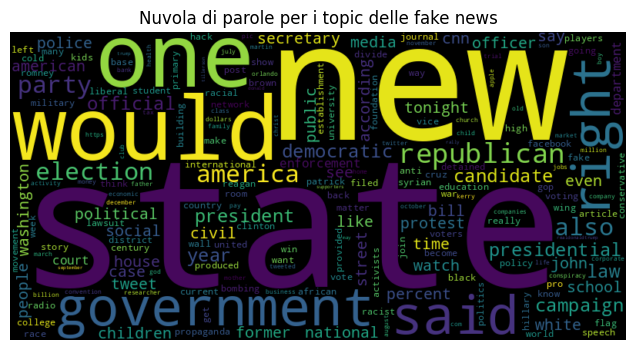

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fake_topic_keywords = [fake_lda_model.show_topic(topic_id, topn=20) for topic_id in range(fake_lda_model.num_topics)]

fake_topic_words = [word for topic in fake_topic_keywords for word, _ in topic]

wc = WordCloud(width=800, height=400, stopwords=stop_words).generate(" ".join(fake_topic_words))

plt.figure(figsize=(8, 4))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvola di parole per i topic delle fake news')
plt.show()

In [ ]:
import nltk
nltk.download('punkt')

fake_news_texts = df_combined[df_combined['label'] == 0]['combined_text']

fake_news_text = ' '.join(fake_news_texts)

from collections import Counter
from nltk import word_tokenize

tokens = word_tokenize(fake_news_text)

word_freq = Counter(tokens)

print("10 parole più comuni nelle fake news:")
print(word_freq.most_common(10))

from nltk import ngrams

bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))

bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

print("\n10 bigrammi più comuni nelle fake news:")
print(bigram_freq.most_common(10))

print("\n10 trigrammi più comuni nelle fake news:")
print(trigram_freq.most_common(10))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


10 parole più comuni nelle fake news:
[(',', 488187), ('the', 484689), ('.', 297425), ('to', 288175), ('of', 234742), ('and', 215633), ('a', 204192), ('in', 154749), ('that', 143637), ('s', 134729)]

10 bigrammi più comuni nelle fake news:
[(('of', 'the'), 52945), ((',', 'and'), 38005), (('in', 'the'), 37257), ((',', 'the'), 28339), (('to', 'the'), 26911), (('.', 'The'), 25244), (('on', 'the'), 17804), (('(', '@'), 17770), (('to', 'be'), 16253), ((',', 'but'), 15897)]

10 trigrammi più comuni nelle fake news:
[(('the', 'United', 'States'), 5578), (('.', 'It', 's'), 5213), (('the', 'White', 'House'), 3874), ((',', 'according', 'to'), 3582), (('one', 'of', 'the'), 3494), ((',', 'it', 's'), 3072), (('.', 'This', 'is'), 2821), ((',', 'and', 'the'), 2726), (('[', 'Video', ']'), 2680), (('(', 'VIDEO', ')'), 2533)]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(df_combined['combined_text'], df_combined['label'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train_tfidf, y_train)

# Predizione sui dati di test
y_pred = logistic_regression_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy * 100, "%")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 98.87527839643653 %
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4650
           1       0.99      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
# Predizione sui dati di addestramento
y_train_pred = logistic_regression_model.predict(X_train_tfidf)

train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy * 100, "%")
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))


Train Accuracy: 99.25664012472855 %
Train Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18831
           1       0.99      0.99      0.99     17087

    accuracy                           0.99     35918
   macro avg       0.99      0.99      0.99     35918
weighted avg       0.99      0.99      0.99     35918



In [ ]:
from sklearn.metrics import confusion_matrix

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[4585   65]
 [  36 4294]]


In [ ]:
import pickle

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(logistic_regression_model, f)

